# En este módulo se realiza la limpieza de datos y se exportan dentro de este mismo directorio "Clean datasets"

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns


## Carga de data set
Dataset obtenido en http://medata.gov.co/dataset/intento-de-suicidio

Como primera tarea y antes de cargar los datos, fueron borrados manualmente(editor de texto) todos aquellos valores que se presetaran como SD(sin datos) para facilitar el procesado de los datos en siguientes pasos. SD-> null (nan)

Ya cargados los datos se procede a cambiar los titulos del dataset, ya que originalmente todos incluian el nombre de la base de datos, esto con el fin de trabajar con mayor facilidad



In [2]:
# df_suicidio=pd.read_csv("suicidio.csv", delimiter = ';' , dtype = 'string')
df_suicidio=pd.read_csv("sivigila_intsuicidio.csv", delimiter = ';')
df_suicidio.info()

titles = df_suicidio.columns
arr = []
for i in titles:
    arr.append(i[21:]) #Eliminar 'sivigila_intsuicidio.'
    
df_suicidio.columns = arr
df_suicidio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sivigila_intsuicidio.id                  11336 non-null  int64  
 1   sivigila_intsuicidio.semana              11336 non-null  int64  
 2   sivigila_intsuicidio.edad_               11336 non-null  float64
 3   sivigila_intsuicidio.uni_med_            11336 non-null  int64  
 4   sivigila_intsuicidio.sexo_               11336 non-null  object 
 5   sivigila_intsuicidio.nombre_barrio       11336 non-null  object 
 6   sivigila_intsuicidio.comuna              11336 non-null  object 
 7   sivigila_intsuicidio.tipo_ss_            11334 non-null  object 
 8   sivigila_intsuicidio.cod_ase_            11336 non-null  object 
 9   sivigila_intsuicidio.fec_con_            11336 non-null  object 
 10  sivigila_intsuicidio.ini_sin_            11336

,id,semana,edad_,uni_med_,sexo_,nombre_barrio,comuna,tipo_ss_,cod_ase_,fec_con_,...,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci,gp_psiquia,psiquiatri,trab_socia,evento,year_
0,1,49,22.0,1,F,Santo Domingo Savio No.1,Popular,S,CCF002,08/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
1,2,49,19.0,1,M,Villa Hermosa,Villa Hermosa,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
2,3,49,52.0,1,F,Los Conquistadores,Laureles,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
3,4,49,58.0,1,F,Las Violetas,Belen,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
4,5,49,32.0,1,M,Florida Nueva,Laureles,C,EPS010,06/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11331,11332,48,17.0,1,F,Pajarito,Robledo,S,CCF002,05/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11332,11333,48,16.0,1,F,Manrique Central No.1,Aranjuez,P,RES001,30/11/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11333,11334,48,16.0,1,F,Barrios de Jesus,Buenos Aires,C,EPS010,04/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015
11334,11335,49,23.0,1,F,Moravia,Aranjuez,C,EPS010,07/12/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTENTO DE SUICIDIO,2015


## Eliminar columnas no relevantes para el problema
Muy relacionado con las entradas y salidas definidas. Inicialmente se habia propuesto predecir la posibilidad de que una poersona intentara el suicidio basados en unas condiciones previas, pero para realizar esto necesitariamos de datos de caracterizacion de personas que no han intentado el suicidio, el dataset con el que se esta trabajando para el caso exactyo de medellin no presenta esta condicion, solo presenta ionfromacion de personas que ya ahn intentado suicuidarse, por lo que debemos replantear un poco lo que se va a predecir(salida).

Al realizar el analisis de los datos presentes en el ds se decidio tomar como salida la columna 'inten_prev', la cual hace referencia a si la persona ha intentado previemente el suicidio , lo cual sera predecido a partir de las condiciones previas['prob_parej', 'enfermedad_cronica',  'prob_econo', 'muerte_fam', 'esco_educ', 'prob_legal', 'suici_fm_a', 'maltr_fps', 'prob_labor', 'prob_consu', 'hist_famil', 'idea_suici', 'plan_suici', 'antec_tran', 'tran_depre', 'trast_personalidad', 'trast_bipolaridad', 'esquizofre', 'antec_v_a', 'abuso_alco',]

La decision de tomar como salida 'intent_prev' se define en aras de no alejarse mucho del probelam prpuesto incialmente, ademas se descubrio que una columna muy parecida 'intentos' no podia ser usada, ya que aproximadamente el 85% eran valores nulos


Para este caso no es relevante la forma de intento de suicidio por lo que se eliminaran las columnas ['ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci'], adicionalmente no son de interes para el problema las columnas ['id','cod_ase_','tip_cas_'] . ['uni_med_', 'evento'] se eliminan ya que solo 1 resgistro tiene un valor diferente  y en el caso del segundo, solo hay un valor posible. Finalmente la columna ['intentos'] presenta un alto porcentaje de valores nulos por lo que tambien se eliminara


In [3]:
# for column in df_suicidio.columns:
#     print(df_suicidio[column].value_counts())

In [4]:
df_suicidio = df_suicidio.drop(['intentos','ahorcamien','arma_corto','arma_fuego','inmolacion','lanz_vacio','lanz_vehic','lanz_agua','intoxicaci','id','cod_ase_','tip_cas_','uni_med_', 'evento'], axis= 1)
df_suicidio.info()

columns_number = len(df_suicidio.columns)
numeric_cols = df_suicidio.select_dtypes(include=[np.number]).columns.values
print('Numeric cols:' + str(len(numeric_cols)))

non_numeric_cols = df_suicidio.select_dtypes(exclude=[np.number]).columns.values
print('Non numeric cols:' + str(len(non_numeric_cols)))
print(non_numeric_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11336 entries, 0 to 11335
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   semana              11336 non-null  int64  
 1   edad_               11336 non-null  float64
 2   sexo_               11336 non-null  object 
 3   nombre_barrio       11336 non-null  object 
 4   comuna              11336 non-null  object 
 5   tipo_ss_            11334 non-null  object 
 6   fec_con_            11336 non-null  object 
 7   ini_sin_            11336 non-null  object 
 8   pac_hos_            11334 non-null  float64
 9   fec_ocurr           11336 non-null  object 
 10  inten_prev          4464 non-null   float64
 11  estado_civ          4154 non-null   float64
 12  escolarid           4154 non-null   float64
 13  prob_parej          4466 non-null   float64
 14  enfermedad_cronica  4466 non-null   float64
 15  prob_econo          4154 non-null   float64
 16  muer

## Datos faltantes

#### Heatmap de datos faltantes
Se observa que desde intento_previo hasta trab_social la cantidad de datos faltantes es muy alta 

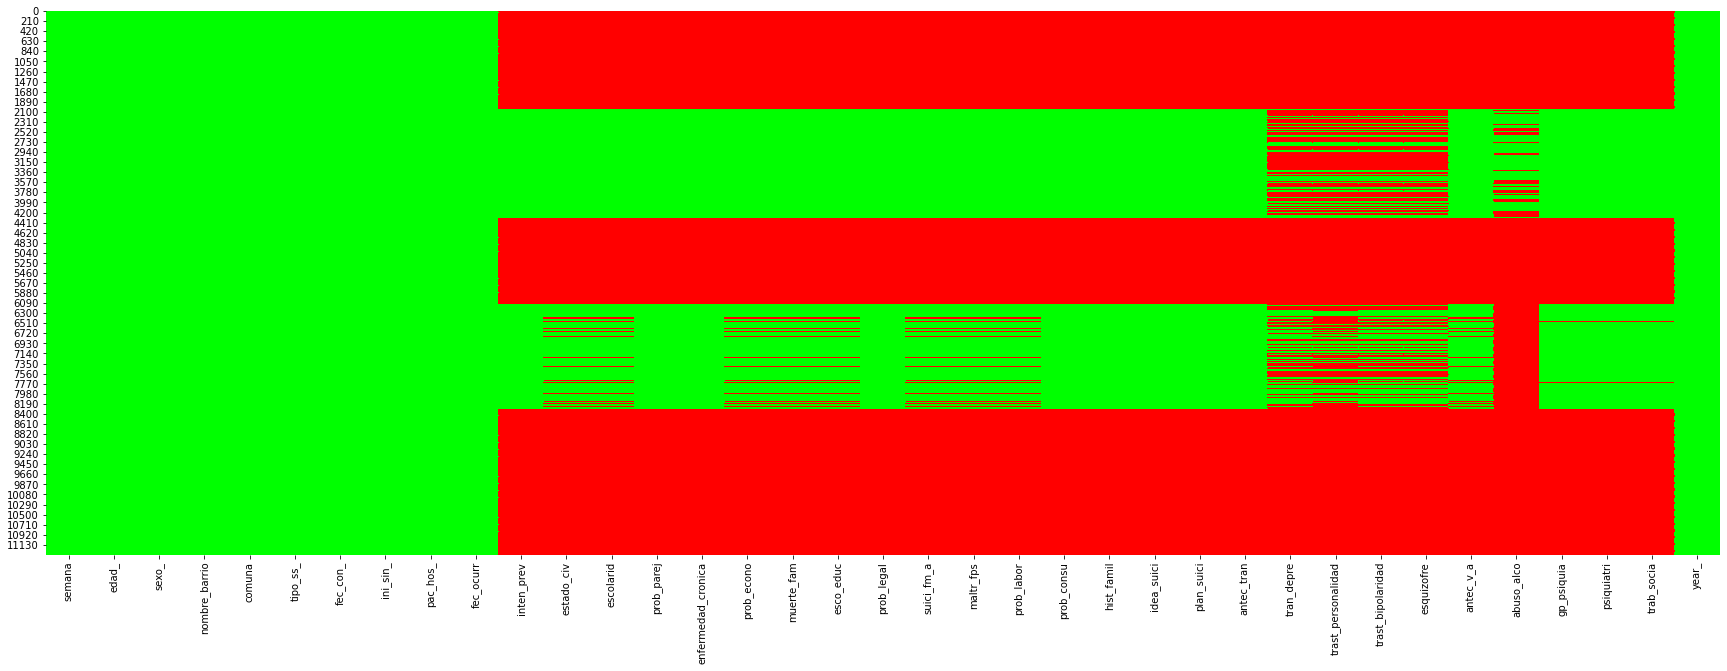

In [5]:
cols = df_suicidio.columns[:]
colours = ['#00FF00', '#ff0000'] # specify the colours - red is missing. green is not missing.
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
sns.heatmap(df_suicidio[cols].isnull(), cmap=sns.color_palette(colours), ax=ax,cbar=False)

#### Porcentaje de datos faltantes

In [6]:
for col in df_suicidio.columns:
    pct_missing = np.mean(df_suicidio[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

tipo_ss_ - 0.02%
pac_hos_ - 0.02%
inten_prev - 60.62%
estado_civ - 63.36%
escolarid - 63.36%
prob_parej - 60.6%
enfermedad_cronica - 60.6%
prob_econo - 63.36%
muerte_fam - 63.36%
esco_educ - 63.36%
prob_legal - 60.6%
suici_fm_a - 63.36%
maltr_fps - 63.36%
prob_labor - 63.36%
prob_consu - 60.6%
hist_famil - 60.6%
idea_suici - 60.6%
plan_suici - 60.6%
antec_tran - 60.61%
tran_depre - 81.53%
trast_personalidad - 84.38%
trast_bipolaridad - 81.53%
esquizofre - 81.52%
antec_v_a - 63.36%
abuso_alco - 85.41%
gp_psiquia - 61.44%
psiquiatri - 61.46%
trab_socia - 61.46%


#### Conteo de registros agrupados por datos faltantes

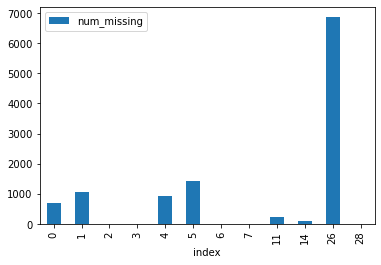

In [7]:
# first create missing indicator for features with missing data
for col in df_suicidio.columns:
    missing = df_suicidio[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
#         print('created missing indicator for: {}'.format(col))
        df_suicidio['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df_suicidio.columns if 'ismissing' in col]
df_suicidio['num_missing'] = df_suicidio[ismissing_cols].sum(axis=1)

df_suicidio['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

## Solucion
### 1. Eliminar registros con 11 o mas datos faltantes
### 2. Eliminar registros con informacion faltante en 'inten_prev'
### 3. Tratar columna con alto porcentaje de nulos, ya sea eliminandolas o imputando datos


In [8]:
# drop rows with a lot of missing values.
ind_missing = df_suicidio[df_suicidio['num_missing'] >= 11].index
df2 = df_suicidio.drop(ind_missing, axis=0)
df2.info()

## Previamente el filtro se estaba haciendo asi:
# df_filtered = df_suicidio[df_suicidio['fec_ocurr'] != '01/01/1900'] 
# aux2 =df_filtered
# aux2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4154 entries, 2048 to 8315
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   semana                        4154 non-null   int64  
 1   edad_                         4154 non-null   float64
 2   sexo_                         4154 non-null   object 
 3   nombre_barrio                 4154 non-null   object 
 4   comuna                        4154 non-null   object 
 5   tipo_ss_                      4154 non-null   object 
 6   fec_con_                      4154 non-null   object 
 7   ini_sin_                      4154 non-null   object 
 8   pac_hos_                      4154 non-null   float64
 9   fec_ocurr                     4154 non-null   object 
 10  inten_prev                    4152 non-null   float64
 11  estado_civ                    4154 non-null   float64
 12  escolarid                     4154 non-null   float64
 13  

In [9]:
df2['inten_prev'].value_counts()

2.0    2548
1.0    1603
4.0       1
Name: inten_prev, dtype: int64

In [10]:
df2 = df2[df2['inten_prev'].notnull()]
df2 = df2[df2['inten_prev'] != 4]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 2048 to 8315
Data columns (total 66 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   semana                        4151 non-null   int64  
 1   edad_                         4151 non-null   float64
 2   sexo_                         4151 non-null   object 
 3   nombre_barrio                 4151 non-null   object 
 4   comuna                        4151 non-null   object 
 5   tipo_ss_                      4151 non-null   object 
 6   fec_con_                      4151 non-null   object 
 7   ini_sin_                      4151 non-null   object 
 8   pac_hos_                      4151 non-null   float64
 9   fec_ocurr                     4151 non-null   object 
 10  inten_prev                    4151 non-null   float64
 11  estado_civ                    4151 non-null   float64
 12  escolarid                     4151 non-null   float64
 13  

#### Revisamos los datos de nuevo

In [11]:
# df2['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')
# df2['num_missing'].value_counts()

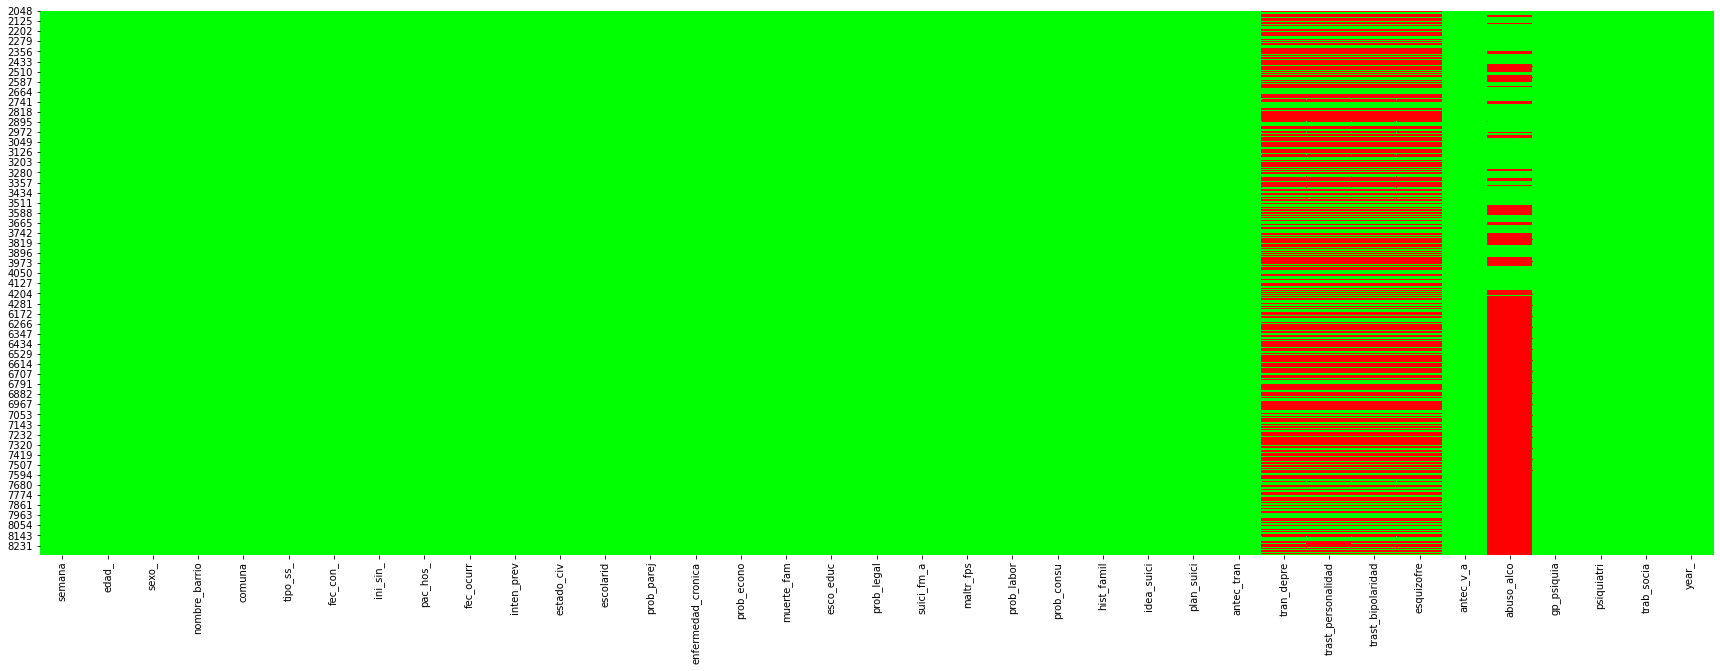

In [12]:
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
cols = df2.columns[:columns_number]
sns.heatmap(df2[cols].isnull(), cmap=sns.color_palette(colours), ax=ax, cbar=False)

In [13]:
for col in df2.columns:
    pct_missing = np.mean(df2[col].isnull())
    if (pct_missing > 0):
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

tran_depre - 57.12%
trast_personalidad - 57.38%
trast_bipolaridad - 57.12%
esquizofre - 57.12%
abuso_alco - 60.23%
gp_psiquia - 0.14%
psiquiatri - 0.19%
trab_socia - 0.19%


In [14]:
df2.iloc[:,:columns_number]

,semana,edad_,sexo_,nombre_barrio,comuna,tipo_ss_,fec_con_,ini_sin_,pac_hos_,fec_ocurr,...,tran_depre,trast_personalidad,trast_bipolaridad,esquizofre,antec_v_a,abuso_alco,gp_psiquia,psiquiatri,trab_socia,year_
2048,17,24.0,F,Aures No.2,Robledo,S,24/04/2018,24/04/2018,1.0,24/04/2018,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2018
2049,17,30.0,M,San Jose del Manzanillo,Altavista,S,23/04/2018,23/04/2018,1.0,23/04/2018,...,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0,2018
2050,17,20.0,F,La Gloria,Belen,C,23/04/2018,23/04/2018,1.0,23/04/2018,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2018
2051,17,23.0,F,Girardot,Castilla,S,25/04/2018,24/04/2018,1.0,24/04/2018,...,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,2.0,2018
2052,17,62.0,M,SIN INFORMACION,SIN INFORMACION,S,14/04/2018,14/04/2018,1.0,14/04/2018,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,13,17.0,F,Andalucia,Santa Cruz,C,28/03/2017,27/03/2017,2.0,27/03/2017,...,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0,2017
8311,40,17.0,F,La Hondonada,Belen,C,05/10/2017,05/10/2017,2.0,05/10/2017,...,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2017
8312,38,17.0,F,SIN INFORMACION,SIN INFORMACION,C,14/09/2017,14/09/2017,2.0,14/09/2017,...,NaN,NaN,NaN,NaN,2.0,NaN,1.0,2.0,2.0,2017
8313,13,17.0,F,San German,Robledo,C,28/03/2017,28/03/2017,2.0,28/03/2017,...,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2017


### Nota
En este punto nos presentamos ante dos opciones: 
1. Eliminar aquella columnas que presentan alto numero de valores nulos (tran_depre, trast_personalidad, trast_bipolaridad, esquizofre, abuso_alco), ya que al ser tan altos no seria razonable imputar datos
2. Depurar aun mas los datos y reducir "drasticamente" el volumne de resgistros con respecto al original pero conservando algunas caracteristicas que consideramos podrian ser relevantes para la prediccion 

Se obtendran dos datasets(cds_few, cds), cada uno aplicando una opcion, para comparalrlos en siguientes etapas al desarrrollar los modelos.

Primero se procede a detectar outliers y terminar de limpiar los datos para que lo uiltom a realizar sea separarlo segun se comento anterior.

### Deteccion de outliers

In [15]:
for column in df2.columns:
    if(column[-7:] != 'missing'):
        print(column)
        print(df2[column].describe())
        
#         print(column)
#     print(column)

semana
count    4151.000000
mean       28.480366
std        13.987087
min         1.000000
25%        17.000000
50%        29.000000
75%        41.000000
max        52.000000
Name: semana, dtype: float64
edad_
count    4151.00000
mean       25.59576
std        12.31087
min         7.00000
25%        17.00000
50%        22.00000
75%        31.00000
max        89.00000
Name: edad_, dtype: float64
sexo_
count     4151
unique       2
top         F 
freq      2722
Name: sexo_, dtype: object
nombre_barrio
count                4151
unique                299
top       SIN INFORMACION
freq                  272
Name: nombre_barrio, dtype: object
comuna
count        4151
unique         22
top       Robledo
freq          358
Name: comuna, dtype: object
tipo_ss_
count     4151
unique       6
top         C 
freq      2698
Name: tipo_ss_, dtype: object
fec_con_
count           4151
unique           708
top       17/09/2017
freq              17
Name: fec_con_, dtype: object
ini_sin_
count           41

In [13]:
# df_filtered = df2[df2['abuso_alco'].notnull()] 

ind_missing = df2[df2['num_missing'] >= 5].index
df_filtered = df2.drop(ind_missing, axis=0)

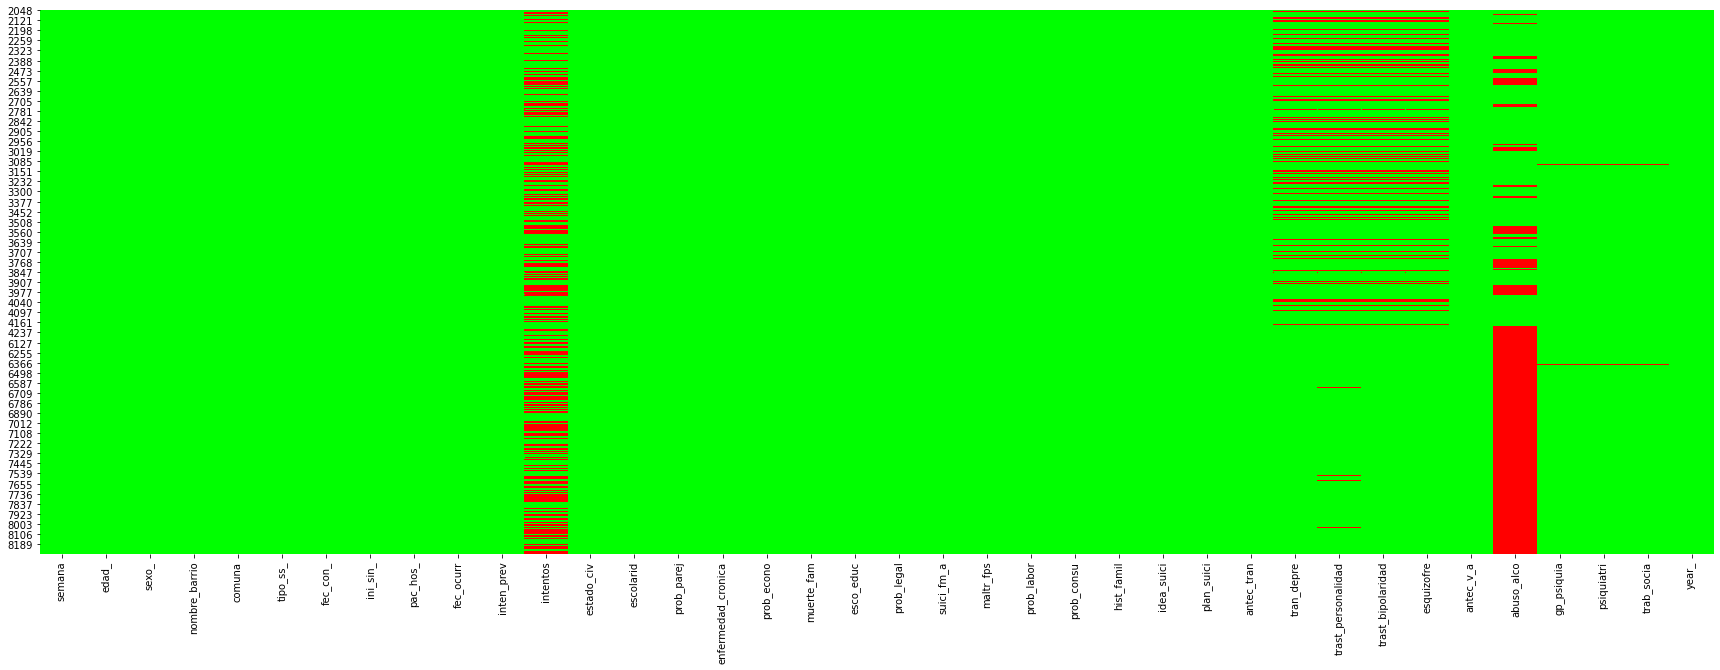

In [14]:
fig, ax = plt.subplots(figsize=(30,10))# Sample figsize in inches
cols = df_filtered.columns[:38]
sns.heatmap(df_filtered[cols].isnull(), cmap=sns.color_palette(colours), ax=ax, cbar=False)

In [15]:
df_filtered.iloc[:,:38]

,semana,edad_,sexo_,nombre_barrio,comuna,tipo_ss_,fec_con_,ini_sin_,pac_hos_,fec_ocurr,...,tran_depre,trast_personalidad,trast_bipolaridad,esquizofre,antec_v_a,abuso_alco,gp_psiquia,psiquiatri,trab_socia,year_
2048,17,24.0,F,Aures No.2,Robledo,S,24/04/2018,24/04/2018,1.0,24/04/2018,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2018
2050,17,20.0,F,La Gloria,Belen,C,23/04/2018,23/04/2018,1.0,23/04/2018,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2018
2052,17,62.0,M,SIN INFORMACION,SIN INFORMACION,S,14/04/2018,14/04/2018,1.0,14/04/2018,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2018
2054,17,16.0,M,El Rincon,Belen,S,23/04/2018,23/04/2018,1.0,23/04/2018,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2018
2056,18,19.0,F,Barrio Colon,La Candelaria,S,03/05/2018,03/05/2018,1.0,03/05/2018,...,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8297,35,17.0,F,La Mansion,Villa Hermosa,C,29/08/2017,29/08/2017,1.0,29/08/2017,...,2.0,2.0,2.0,1.0,2.0,NaN,1.0,2.0,2.0,2017
8301,38,17.0,M,Santa Ines,Manrique,N,17/09/2017,17/09/2017,1.0,17/09/2017,...,1.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2017
8304,39,17.0,M,SIN INFORMACION,SIN INFORMACION,C,30/09/2017,30/09/2017,1.0,30/09/2017,...,1.0,1.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,2017
8309,13,17.0,F,Andalucia,Santa Cruz,C,28/03/2017,27/03/2017,2.0,27/03/2017,...,1.0,2.0,2.0,2.0,2.0,NaN,1.0,2.0,2.0,2017


# Rivera


In [16]:
from numpy import ones,vstack
from numpy.linalg import lstsq
points = [(2017,1862),(2018,2263)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

Line Solution is y = 401.000000000163x + -806955.0000003288


<ipython-input-16-53d6c23875e0>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


In [17]:
df_aux=pd.read_csv("suicidio2.csv", delimiter = ';')
titles_aux = df_aux.columns
arr_aux = []
for i in titles_aux:
    arr_aux.append(i[21:])

df_aux.columns = arr_aux

In [18]:
df_aux[['ahorcamien','arma_corto', 'arma_fuego', 'inmolacion', 'lanz_vacio', 'lanz_vehic', 'lanz_agua', 'intoxicaci']]

,ahorcamien,arma_corto,arma_fuego,inmolacion,lanz_vacio,lanz_vehic,lanz_agua,intoxicaci
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
11331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En esta limpieza también se realiza un primer filtro de características
- "X" e "Y" corresponden a la latitud y longitud de el accidente, dificilmente un accidente pueda ocurrir
en las mismas coordenadas, no se considera util.
- "OBJECTID" Es la clave primaria dentro de una base de datos mongo por lo que no es una carecterística
- "RADICADO" Es un valor único con el que se radicó cada accidente por lo tanto no es relevante
- "FECHA" los datasets ya cuentan con una fecha desglosada en mes y día.
- "MES_NOMBRE" no todas las filas tienen completo este campo, además de que ya se cuenta con una columna "MES" con
el número del mes.
- "DIRECCION_ENC" es otro formato para la dirección, por lo que se puede descartar.

In [19]:
for i in range(3):
    datalist[i]=datalist[i].drop(['X','Y','OBJECTID', 'RADICADO','FECHA','MES_NOMBRE','DIRECCION_ENC','CBML'],axis=1)

# print(datalist[0].columns)
# a=datalist[0]
# print(a['BARRIO'].unique())# for column in datalist[0].columns:
#     print(column)
#     print(datalist[0][column].unique())


NameError: name 'datalist' is not defined

Lo siguiente es verificar la presencia de datos atípicos o mal escritos en las clases
y sean reemplazados manualmente en un archivo csv.


In [ ]:
dataTotal=pd.concat(datalist,axis=0)
# print(dataTotal.columns)
dia_nombre=dataTotal['DIA_NOMBRE'].unique()
clase=dataTotal['CLASE'].unique()
tipo_geocod=dataTotal['TIPO_GEOCOD'].unique()
gravedad=dataTotal['GRAVEDAD'].unique()
barrio=dataTotal['BARRIO'].unique()
comuna=dataTotal['COMUNA'].unique()
mes=dataTotal['MES'].unique()
dia=dataTotal['DIA'].unique()
diseno=dataTotal['DISENO'].unique()
print(barrio)

In [ ]:
dataTotal.to_csv('dataTotal.csv')


La limpieza manual se hizo con la ayuda de una lista de valores únicos en cada columna donde se verificó
uno por uno que estuviera bien escrito y si existían valores que se estuvieran refiriendo a lo mismo como era el
caso de la columna "BARRIO" donde hallámos valores "San Antonio de parado" y "Corregimiento san antonio de prado"
que se referían al mismo pero que al codificarse posteriormente son interpretados conmo distintos.

Una vez que se hizo una limpieza manual de datos de clases mal escritos, cargamos nuevamente el dataset


In [ ]:
dataTotal2=pd.read_csv("dataTotalv2.csv")

Durante la limpieza manual de se omitieron valores atípicos encontrados para las columnas de "BARRIO" y "COMUNA"
donde habían valores como: 'Sin Nombre','0','Inst','AUC1' entre otros para buscar cuántas filas los contenian
y tomar decisiones sobre que hacer con ellos.
Estos datos atípicos tuvieron pocas apareiciones 2 o 3 por cada uno, por lo que se tomó la decisión de eliminar
la fila que los contenía.


In [ ]:
column=['BARRIO','COMUNA']
atypical=[['Sin Nombre','0','Inst','AUC1','6001','9086','7001','9004'],['AU','Sin Inf']]
a=zip(column,atypical)

#borra los datos atípicos de la segunda versión del dataset
for i ,j in a:
    for k in j:
        dataTotal2 = dataTotal2.drop(dataTotal2[dataTotal2[i] ==k].index)

In [ ]:
import matplotlib.pyplot as plt
nan_columns = []
nan_values = []

for column in dataTotal2.columns:
    b=dataTotal2[column].isnull().sum();
    if b>0:
        nan_columns.append(column)
        nan_values.append(b)

fig, ax = plt.subplots(figsize=(10,5))
plt.title('NaN por columna, total='+ str(dataTotal2.isnull().sum().sum()))
plt.bar(nan_columns, nan_values)

print(dataTotal2.isnull().sum().sum())

En el gráfico anterior se aprecian los valores nulos (NaN) por cada columna que los contiene
para un total de 736 que si bien es un número pequeño comparado con el total de datos de 113.659
se optó por rellenarlos en lugar de elimarlos, la estratégia a usar para esto fue la de 'most_frequent' que
por su traducción al español completa con el valor más frecuente en cada columna.

In [ ]:
#datos nulos
from sklearn.impute import SimpleImputer
print(dataTotal2.isnull().sum())
strategy = SimpleImputer(strategy='most_frequent')
dataTotalF=strategy.fit_transform(dataTotal2)
print(dataTotalF)

In [ ]:
newDf = pd.DataFrame(data=dataTotalF, columns=dataTotal2.columns)
print(newDf.isnull().sum())

# El dataset se encuentra sin datos atípicos o extraños.

In [ ]:
newDf.to_csv('cleanData.csv',index=False)

